# Временные ряды

Давайте посмотрим, как подгонять модель `SARIMA(p,d,q)x(P,D,Q)` под временной ряд и анализировать качество полученной модели.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm # все, для работы с рядами
from scipy.special import inv_boxcox # обратное преобразование Бокса-Кокса 
from itertools import product # произведения множеств
from statsmodels.stats.descriptivestats import sign_test
import warnings

В файле `wine.csv` содержаться данные о месячных продажах вина в Австралии. Требуется оценить выбрать оптимальную по AIC критерию модель SARIMA и построить прогноз продаж на следующие 3 года.

In [4]:
# импортируем данные
# здесь еще мы дополнительно сделали столбец 'month' индексом,
# преобразовали его содержимое в тип "дата" и указали, что у нас американский формат даты (сначала) 

data = pd.read_csv("wine.csv", sep=',', index_col=['month'], parse_dates=['month'], dayfirst=False) 

## 1. Визуальный анализ и предобработка

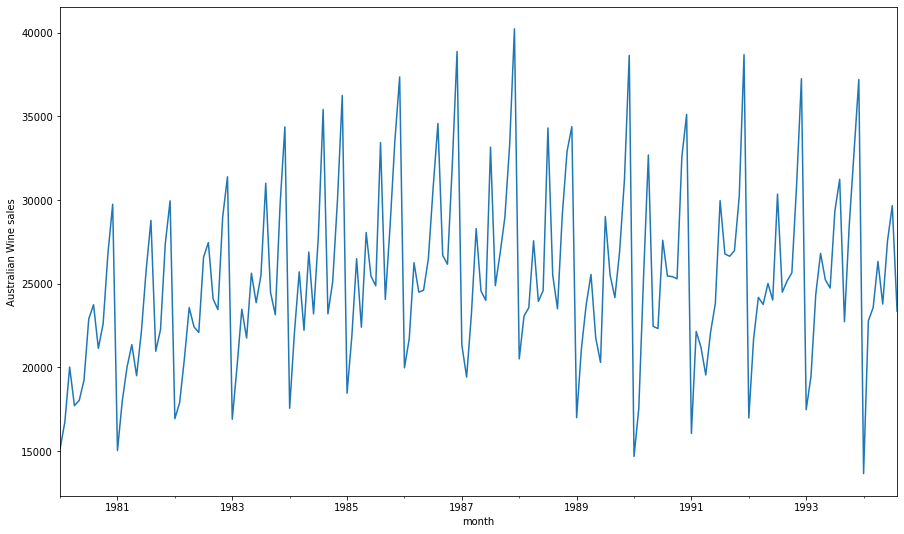

In [7]:
plt.figure(figsize=(15,9))
data.sales.plot()
plt.ylabel('Australian Wine sales');

Мы видим, что временной ряд не содержит пропуски. Начало ряда не сильно отличается от конца ряда, поэтому мы ничего удалять не будем. У ряда видна очевидная годовая сезонность (больше всего вина продается в декабре, меньше всего — в январе). Кроме этого, есть возможный цикл или меняющийся тренд. Наконец, дисперсия ряда увеличивается со временем.  

Удобный инструмент для визуального анализа ряда — его *STL-декомпозиция*. STL расшифровывается как A Seasonal-Trend Decomposition Procedure Based on Loess, и это процедура декомпозиции временного ряда на сезонную, трендовую составляющие и на остатки, использующую метод локальных регрессий (LOESS). И именно с помощью LOESS и происходит сглаживание исходного ряда данных.

<Figure size 1080x648 with 0 Axes>

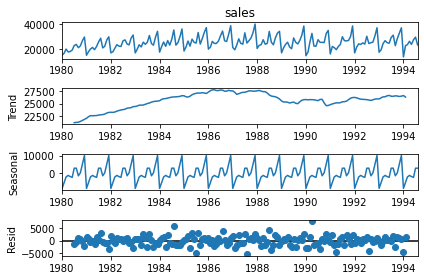

In [9]:
plt.figure(figsize=(15,9))
sm.tsa.seasonal_decompose(data.sales).plot()
plt.show()

## 2. Стабилизация дисперсии

Стабилизировать дисперсию мы будем с помощью преобразованися Бокса-Кокса. В Python реализовано это преобразование с автоматичесим подбором параметра $\lambda$. Им мы и воспользуемся. Преобразованный ряд запишем в тот же DataFrame.

In [10]:
data['sales_boxcox'], lmbd = stats.boxcox(data['sales'])

In [11]:
print("Оптимальный параметр преобразования Бокса-Кокса: ", lmbd)

Оптимальный параметр преобразования Бокса-Кокса:  0.23667537162383442


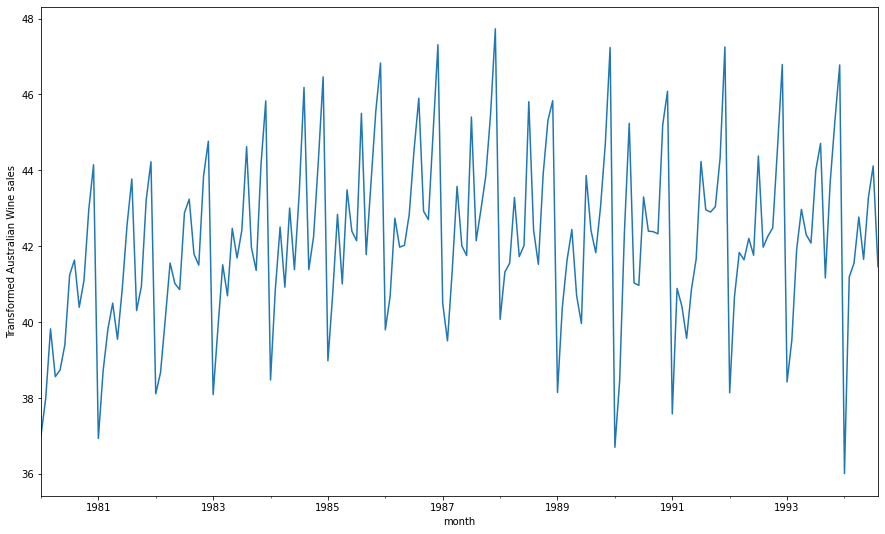

In [29]:
plt.figure(figsize=(15,9))
data.sales_boxcox.plot()
plt.ylabel('Transformed Australian Wine sales');

После преобразования Бокса-Кокса дисперсия ряда стала более стабильной. Посмотрим на STL-декомпозицию преобразованного ряда.

<Figure size 1080x648 with 0 Axes>

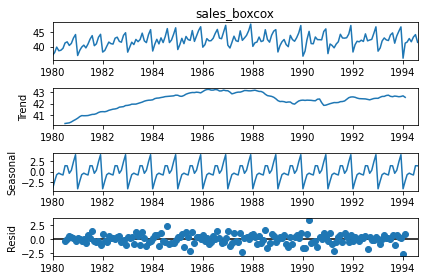

In [30]:
plt.figure(figsize=(15,9))
sm.tsa.seasonal_decompose(data.sales_boxcox).plot();

## 3. Дифференцирование

По построенным графикам видно, что данные обладают сезонностью и, возможно, трендом, который необходимо удалить. Этот шаг необходим, чтобы сделать ряд стационарным и подогнать к нему модель SARMA (у нас есть гарантии, что эта модель хорошо описывает только стационарные ряды). Как было сказано на лекции: лучше всего начинать с сезонного дифференцирования.

In [31]:
data['sales_boxcox_diff'] = data.sales_boxcox - data.sales_boxcox.shift(12)

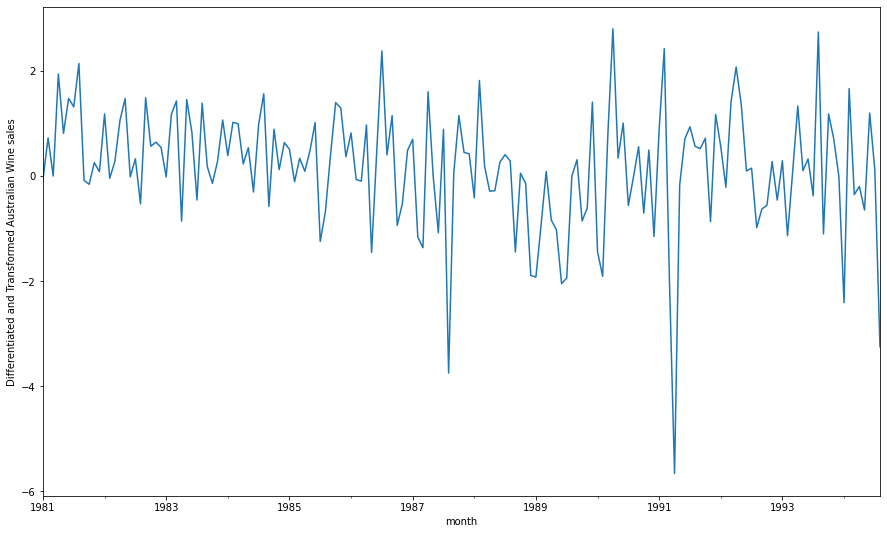

In [32]:
plt.figure(figsize=(15,9))
data.sales_boxcox_diff[12:].plot()
plt.ylabel('Differentiated and Transformed Australian Wine sales');

<Figure size 1080x648 with 0 Axes>

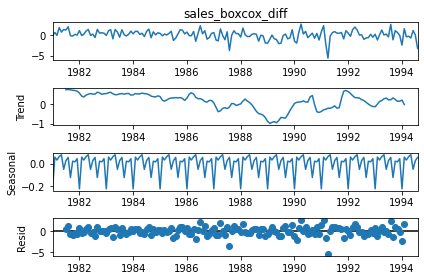

In [33]:
plt.figure(figsize=(15,9))
sm.tsa.seasonal_decompose(data.sales_boxcox_diff[12:]).plot();

Видим, что после сезонного дифференцирования пропала только сезонность, но ряд не стал стационарным  (например, потому что у него есть заметный тренд). Сделаем еще одно обычное дифференцирование.

In [34]:
data['sales_boxcox_diff2'] = data.sales_boxcox_diff - data.sales_boxcox_diff.shift(1)

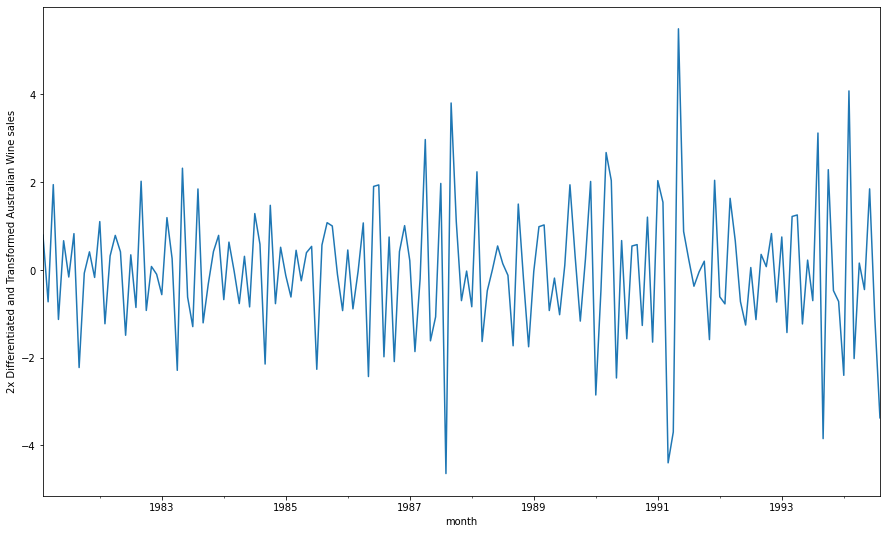

In [35]:
plt.figure(figsize=(15,9))
data.sales_boxcox_diff2[13:].plot()
plt.ylabel('2x Differentiated and Transformed Australian Wine sales');

<Figure size 1080x648 with 0 Axes>

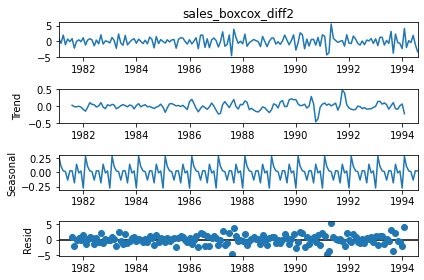

In [79]:
plt.figure(figsize=(15,9))
sm.tsa.seasonal_decompose(data.sales_boxcox_diff2[13:]).plot();

Теперь наш ряд стал похож на стационарный. Попробуем формально отвергнуть гипотезу о нестационарности с помощью критерия Дики-Фуллера.

В практической работе стационарность ряда означает отсутствие:
- тренда;
- систематических изменений дисперсии;
- строго переодических флуктуаций;
- систематически изменяющихся взаимосвязей между элементами ряда.

In [37]:
print("Критерий Дики-Фуллера для преобразованного ряда: pvalue =",
      sm.tsa.stattools.adfuller(data.sales_boxcox_diff2[13:])[1])

Критерий Дики-Фуллера для преобразованного ряда: pvalue = 2.1237369978270874e-06


Гипотеза о нестационарности уверенно отвергается. Для эксперимента проверим с помощью этого критерия еще начальный ряд и ряд после преобразования Бокса-Кокса.

In [38]:
print("Критерий Дики-Фуллера для начального ряда: pvalue =", sm.tsa.stattools.adfuller(data.sales)[1])

Критерий Дики-Фуллера для начального ряда: pvalue = 0.05116115205187653


In [39]:
print("Критерий Дики-Фуллера для преобразованного ряда: pvalue =",
      sm.tsa.stattools.adfuller(data.sales_boxcox_diff[12:])[1])

Критерий Дики-Фуллера для преобразованного ряда: pvalue = 0.12831728018434935


Видим, что для начального ряда гипотеза о нестационарности отвергается на уровне 6%. Это означает, что данный критерий не являются универсальным и всегда работающим. Поэтому нужно всегда оценивать свои выводы по графикам.

## 4. Выбор начальных значений для $p$, $q$ и $P$, $Q$.

Чтобы выбрать начальные значения для $p,q$ и $P,Q$, необходимо построить графики автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF).

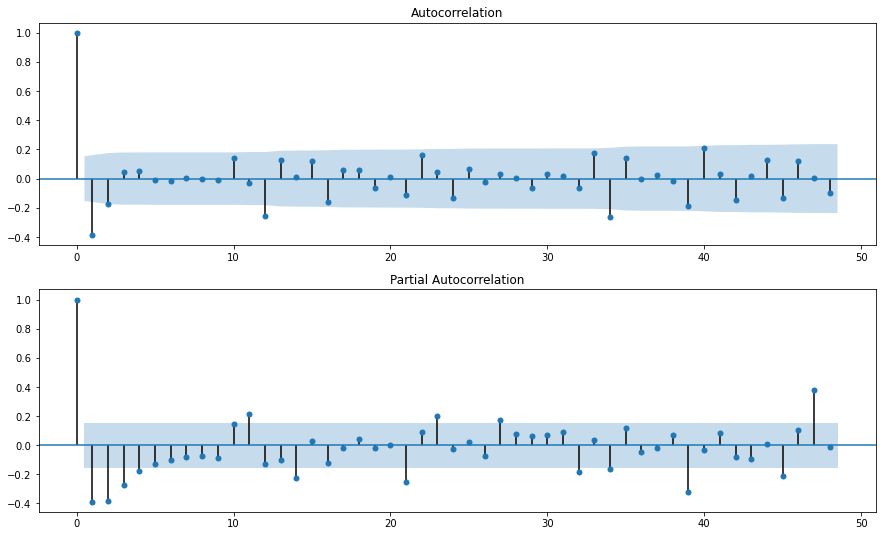

In [40]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15,9)) 

sm.graphics.tsa.plot_acf(data.sales_boxcox_diff2[13:].values.squeeze(), lags=48, ax=ax1)
sm.graphics.tsa.plot_pacf(data.sales_boxcox_diff2[13:].values.squeeze(), lags=48, ax=ax2)

plt.show()

График автокорреляционных функций, то есть коррелограмма независимо от значений в первом лаге у стационарных рядов должны быстро убывать после нескольких первых значений, а у нестацинарных рядов ее значение в первом лаге близки к единице, а затем она медленно убывает по угасайщей экспоненте (синусоиде).

Согласно этим графикам, в качестве начальных значений необходимо взять: $Q=1$, $q=2$, $P=2$, $p=4$.

## 5. Перебор и сравнение моделей для всех $p,q$ и $P,Q$, которые меньше или равны начальным значениям

Для рядов с переодической сезонной компнентой применяется модель авторегрессии проинтегрированного скользящего среднего с сезонностью, которая в обозначениях Бокса-Дженкинса записывается как $ARIMA(p, d, q)(ps, qs, ds)$, где $ps$ — сезонная авторегрессия; $ds$ — сезонный расностный оператор; $qs$ — сезонное скользящее среднее. 

In [41]:
# создадим список из значений параметров для перебора моделей
d = D = 1
ps = range(0, 5)
qs = range(0, 3)
Ps = range(0, 3)
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)

In [42]:
# посмотрим, сколько моделей нам предстоит обучить
len(parameters_list)

90

In [43]:
results = [] # здесь будем хранить результаты
warnings.filterwarnings('ignore') # не для всех параметров модели будут обучаться; отключим предупреждения

for param in parameters_list:
    #try-except нужен, чтобы обработать случаи, когда модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.sales_boxcox, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('Wrong parameters:', param)
        continue
    
    results.append([param, model.aic])

In [47]:
# преобразуем результаты в DataFrame и добавим названия столбцов
result_table = pd.DataFrame(results,  columns=['Parameters', 'AIC'])

In [48]:
# выведем 5 лучших по AIC моделей 
result_table.sort_values(by='AIC', ascending=True).head()

,Parameters,AIC
43,"(2, 1, 0, 1)",474.828532
45,"(2, 1, 1, 1)",475.813087
67,"(3, 2, 0, 1)",476.194725
49,"(2, 2, 0, 1)",476.310857
61,"(3, 1, 0, 1)",476.750432


Лучшей моделью получилась `SARIMAX(2, 1, 1)x(0, 1, 1, 12)`. Именно на ней мы и остановимся. Заметим, что следующие по AIC модели имеют больше параметров, а чем больше параметров у модели — тем более она неустойчива и тем хуже ее вероятностные свойства. Поэтому иногда, если AIC у двух моделей отличается незначительно, то отдать предпочтение нужно той, которая содержит меньше параметров. Так, иногда, стоит выбирать модели, которые находятся на 2-3 месте.

In [49]:
best_model = sm.tsa.statespace.SARIMAX(data.sales_boxcox, order=(2,1,1), seasonal_order=(0,1,1,12)).fit(disp=-1)

In [50]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       sales_boxcox   No. Observations:                  176
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -232.414
Date:                            Mon, 19 Jul 2021   AIC                            474.829
Time:                                    17:07:36   BIC                            490.297
Sample:                                01-01-1980   HQIC                           481.109
                                     - 08-01-1994                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1506      0.085     -1.763      0.078      -0.318       0.017
ar.L2         -0.1990      0.111     -1.799      0.072      -0.416       0.018
ma.L1         -0.8394      0.055    -15.258      0.000      -0.947      -0.732
ma.S.L12      -0.6689      0.052    -12.746      0.000      -0.772      -0.566
sigma2         0.9590      0.081     11.768      0.000       0.799       1.119
===================================================================================
Ljung-Box (Q):                       40.31   Jarque-Bera (JB):                25.57
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               2.37   Skew:                            -0.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 6. Анализ остатков

Чтобы убедится, что модель хорошая, осталось проанализировать остатки. Сначала посмотрим на них.

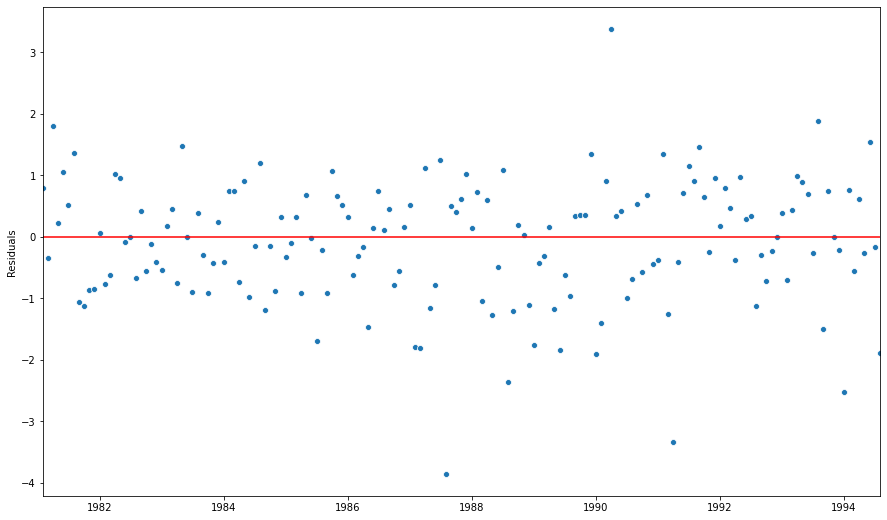

In [71]:
residuals = best_model.resid[13:]
plt.figure(figsize=(15,9))
sns.scatterplot(data=residuals)
plt.axhline(y=0.0, color='r', linestyle='-')
plt.xlim([pd.Timestamp('1981-02-01'), pd.Timestamp('1994-08-01')])
plt.ylabel('Residuals');

Визуально остатки выглядят хорошо. Не видны признаки смещенности, нестационарности или какой-либо зависимости.

### Несмещенность
Проверим несмещенность с помощью критерия знаков (самый универсальный критерий).

In [72]:
from statsmodels.stats.descriptivestats import sign_test
print("Критерий знаков для остатков: pvalue =", sign_test(residuals)[1])

Критерий знаков для остатков: pvalue = 0.7541603898054363


### Стационарность
Проверим стационарность с помщью критерия Дики-Фуллера.

In [70]:
print("Критерий Дики-Фуллера для остатков: pvalue =", sm.tsa.stattools.adfuller(residuals)[1])

Критерий Дики-Фуллера для остатков: pvalue = 1.8463823376401758e-23


### Неавтокоррелированность
Чтобы определить независимость остаткок, посмотрим на график автокорреляционной функции.

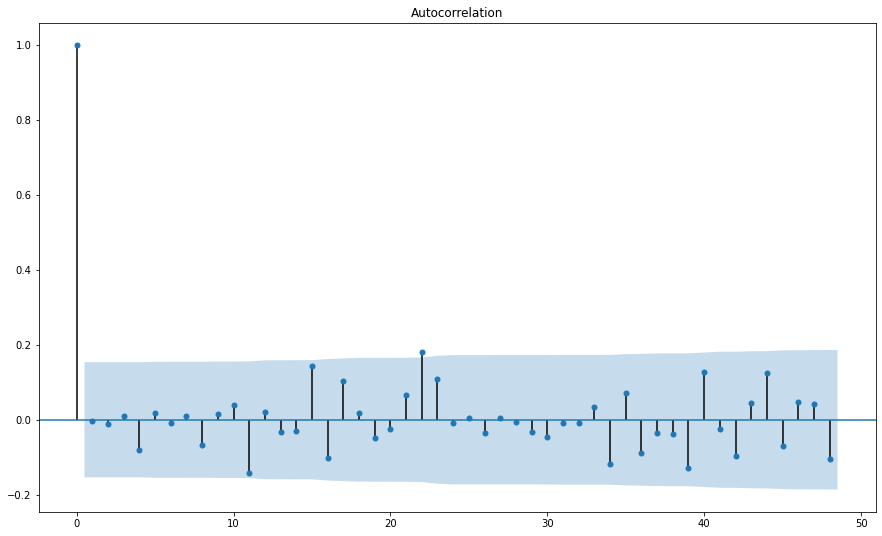

In [75]:
_, ax = plt.subplots(figsize=(15,9))
sm.graphics.tsa.plot_acf(residuals.values.squeeze(), lags=48, ax=ax);

Еще обратим внимание, что в `summary` содержалась информация о Q-критерии Льюнга-Бокса. Этот тест не отвергает нулевую гипотезу о независимости остатков.

## График модель + ряд

Выведем на графике наш ряд и построенную для него модель. Для этого необходимо сделать обратное преобразование Бокса-Кокса.

In [80]:
# сохраним значения нашей модели (не забудем сделать обратное преобразование Бокса-Кокса)
data['model'] = inv_boxcox(best_model.fittedvalues, lmbd)

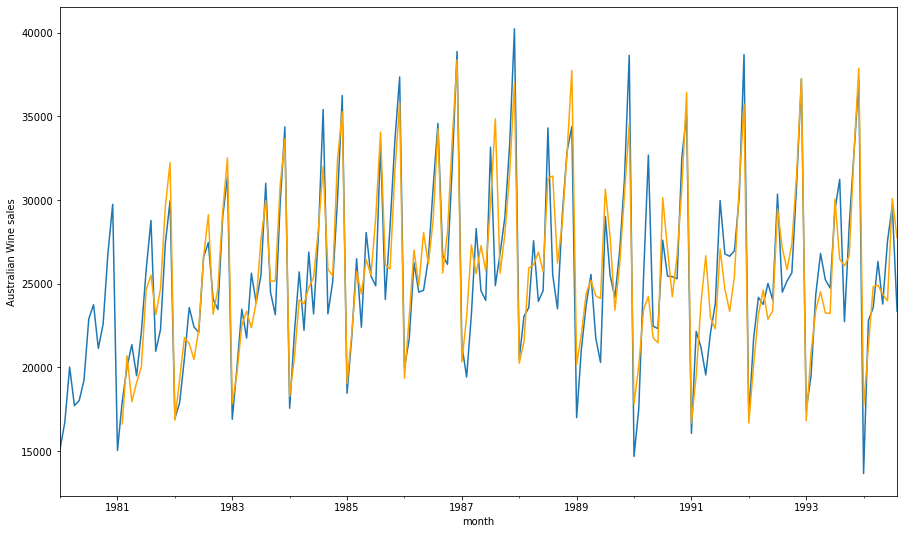

In [86]:
plt.figure(figsize=(15,9))
data.sales.plot()
data.model[13:].plot(color='orange')
plt.ylabel('Australian Wine sales');

## Прогноз

Чтобы сделать прогноз, необходимо воспользоваться методом `predict`. Так как у датафрейма индексами являются даты, нам необходимо еще записать даты для прогноза. Будем хранить значения ряда и прогноза в `new_data`.

In [98]:
# сделаем подготовительную работу
plot_data = data[['sales','model']]

date_list = [pd.to_datetime("1994-09-01") + np.timedelta64(x, 'M') for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns=plot_data.columns)
plot_data = pd.concat([plot_data, future])

In [99]:
# построим предсказание, сделаем для него обратное преобразование Бокса-Кокса
start, end = 176, 211
forecast = inv_boxcox(best_model.predict(start=start, end=end), lmbd)
forecast.index = date_list

In [100]:
# запишем его в столбец Model
plot_data.loc[date_list, 'model'] = forecast

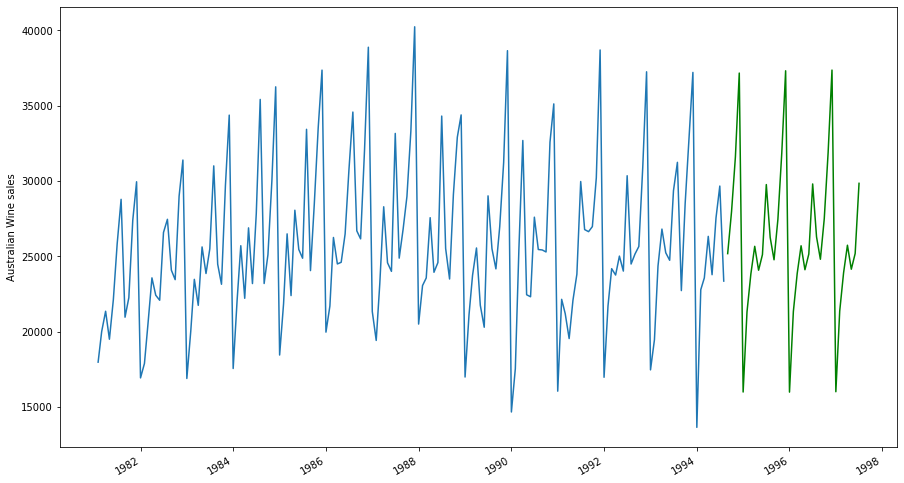

In [110]:
plt.figure(figsize=(15,9))
plot_data.sales[13:].plot()
plot_data.model[start:end].plot(color='g')
plt.ylabel('Australian Wine sales');

***
В файле shampoo.csv содержатся данные о ежемесячных продажах шампуня за трехлетний период. Подберите модель в классе SARIMA для этого временного ряда.Сделайте предсказание на три месяца вперед.

In [3]:
shampoo = pd.read_csv('shampoo.csv', index_col=['Month'])
shampoo.head()

,Sales
Month,
1-01,266.0
1-02,145.9
1-03,183.1
1-04,119.3
1-05,180.3


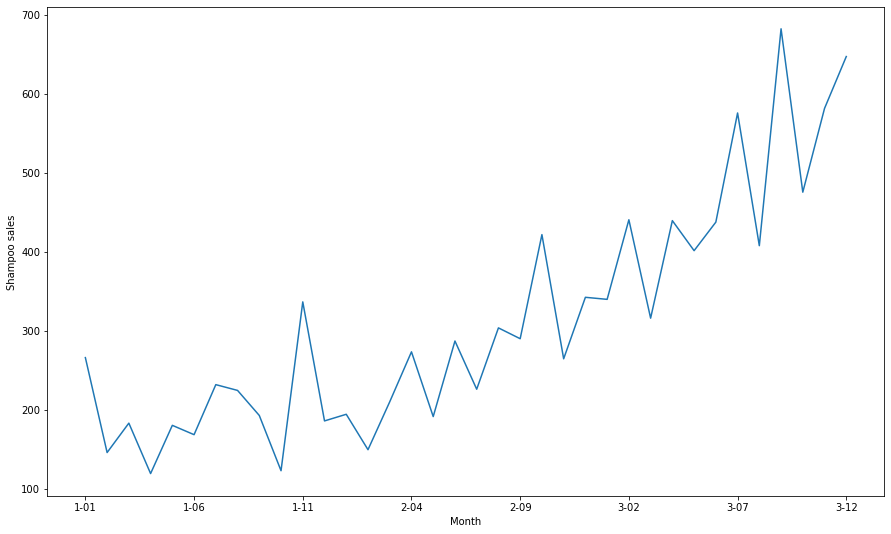

In [4]:
# посмотрим на наш временной ряд
plt.figure(figsize=(15,9))
shampoo['Sales'].plot()
plt.ylabel('Shampoo sales');

Судя по графику, пропусков в данных нет, начало и конец графика не отличаются явным образом друг от друга (не нужно удалять начало временного ряда). Есть явно выраженный восходящий тренд, очевидной сезонности, вроде бы, нет. Кажется, что дисперсия ряда со временем заметно не меняется.

<Figure size 1080x648 with 0 Axes>

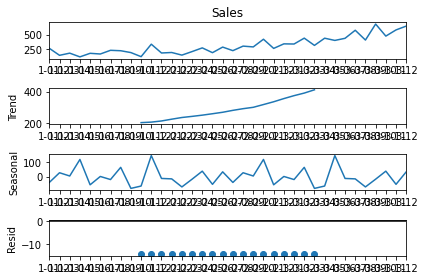

In [7]:
# выполним STL-декомпозицию ряда
plt.figure(figsize=(15,9))
sm.tsa.seasonal_decompose(shampoo['Sales'], period=18).plot();

STL-декомпозиция подтвердила выводы о наличии сильного восходящего тренда. Также видно, что есть значимая сезонность.

Сначала займемся стабилизацией дисперсии; хотя визуально кажется, что она не меняется со временем, лишним это все равно не будет.

In [8]:
shampoo['Sales_boxcox'], lmbd = stats.boxcox(shampoo['Sales'])
print("Оптимальный параметр преобразования Бокса-Кокса: ", lmbd)

Оптимальный параметр преобразования Бокса-Кокса:  -0.09471316578026066


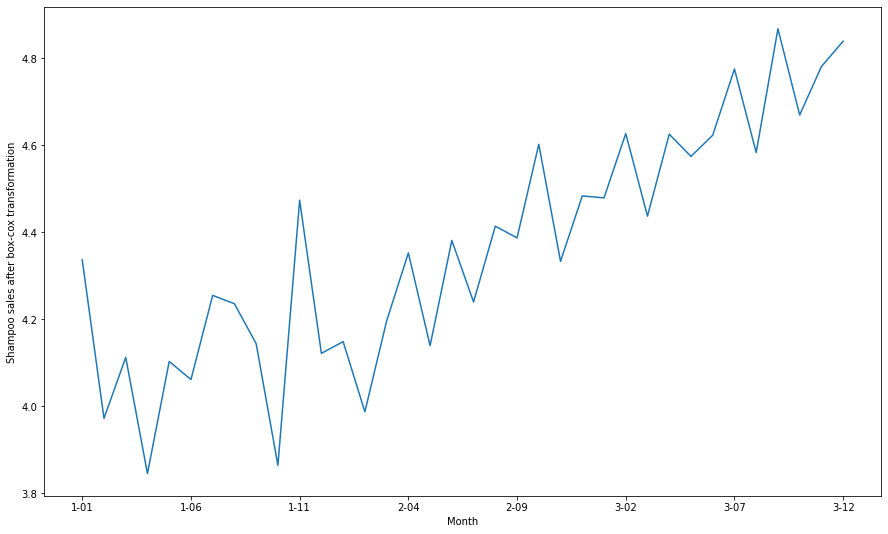

In [9]:
# посмотрим на получившийся временной ряд
plt.figure(figsize=(15,9))
shampoo['Sales_boxcox'].plot()
plt.ylabel('Shampoo sales after box-cox transformation');

<Figure size 1152x576 with 0 Axes>

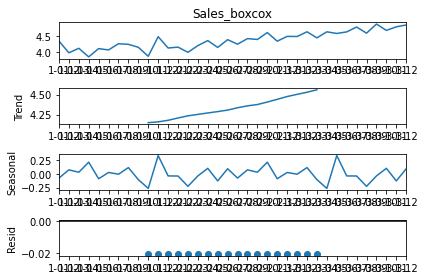

In [10]:
# также посмотрим на STL-декомпозицию преобразованного ряда
plt.figure(figsize=(16,8))
sm.tsa.seasonal_decompose(shampoo['Sales_boxcox'], period=18).plot();

Судя по STL-декомпозиции, преобразование Бокса-Кокса позволило нам избавиться от сезонности. Поэтому не будем использовать сезонное дифференцирование, сразу перейдем к обычному.

In [11]:
# попробуем избавиться от тренда с помощью дифференцирования
shampoo['Sales_boxcox_od1'] = shampoo['Sales_boxcox'] - shampoo['Sales_boxcox'].shift(1)

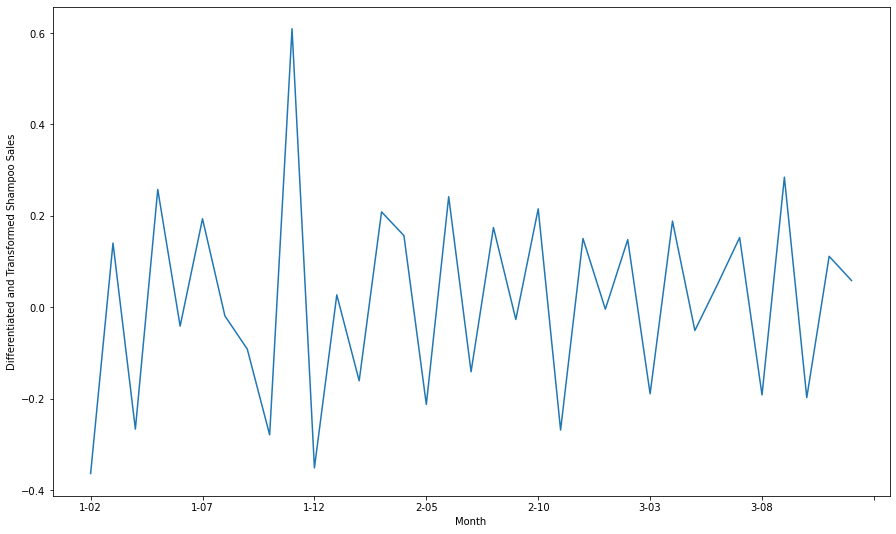

In [12]:
plt.figure(figsize=(15,9))
shampoo['Sales_boxcox_od1'][1:].plot()
plt.ylabel('Differentiated and Transformed Shampoo Sales');

<Figure size 1080x648 with 0 Axes>

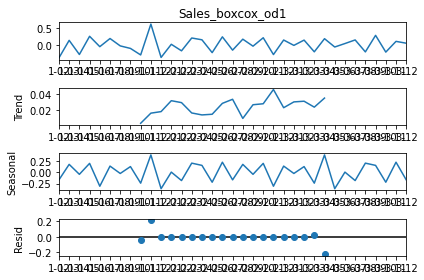

In [13]:
plt.figure(figsize=(15,9))
sm.tsa.seasonal_decompose(shampoo['Sales_boxcox_od1'][1:], period=17).plot();

Нам удалось избавиться от тренда, но теперь получилась, что сезонность сильно влияет на преобразованный временной ряд (значения временного ряда колеблятся от -0.25 до 0.5, а сезонности - от -0.4 до 0.4). Но попытки избавиться от сезонности "за кадром" не привели к желаемому результату, поэтому оставим все как есть.

In [14]:
# проверим при помощи критерия Дики-Фуллера гипотезу о нестационарности получившегося временного ряда
print("Критерий Дики-Фуллера для итогового ряда: pvalue =",
      sm.tsa.stattools.adfuller(shampoo['Sales_boxcox_od1'][1:])[1])

Критерий Дики-Фуллера для итогового ряда: pvalue = 0.001568303430251224


Критерий Дики-Фуллера отвергает гипотезу о том, что наш итоговый ряд не является стационарным.

In [16]:
# заодно еще и посмотрим на критерий Дики-Фуллера для двух других наших временных рядов
print("Критерий Дики-Фуллера для начального ряда: pvalue =", sm.tsa.stattools.adfuller(shampoo['Sales'])[1])
print("Критерий Дики-Фуллера для ряда после преобразования Бокса-Кокса: pvalue =",
      sm.tsa.stattools.adfuller(shampoo['Sales_boxcox'])[1])

Критерий Дики-Фуллера для начального ряда: pvalue = 1.0
Критерий Дики-Фуллера для ряда после преобразования Бокса-Кокса: pvalue = 0.9978319700198924


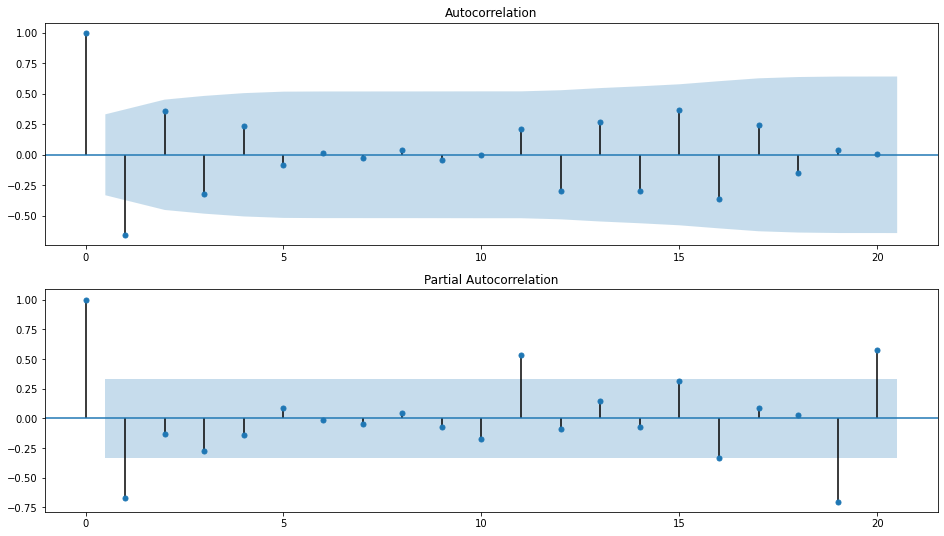

In [17]:
# построим графики автокорреляционной и частной автокорреляционной функций
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(16,9)) 
sm.graphics.tsa.plot_acf(shampoo['Sales_boxcox_od1'][1:].values.squeeze(), lags=20, ax=ax1)
sm.graphics.tsa.plot_pacf(shampoo['Sales_boxcox_od1'][1:].values.squeeze(), lags=20, ax=ax2);

По графику автокорреляции получаем оценки для $q=1$, $Q=0$. По графику частной автокорреляции получаем оценки для $p=1$, $P=0$.

In [18]:
# создадим список из значений параметров для перебора моделей
d = 1 # количество обычных дифференцирований
D = 0 # количество сезонных дифференцирований
# ниже параметры идут в следующем порядке: p, q, P, Q
parameters_list = [[0, 0, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [1, 1, 0, 0]]

In [19]:
results = []
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(shampoo['Sales_boxcox'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 0)).fit(disp=-1)
    except ValueError:
        print('Wrong parameters:', param)
        continue
    
    results.append([param, model.aic])

In [20]:
result_table = pd.DataFrame(results, columns=['Parameters', 'AIC'])

In [21]:
result_table.sort_values(by='AIC', ascending=True).head()

,Parameters,AIC
2,"[1, 0, 0, 0]",-25.354846
3,"[1, 1, 0, 0]",-25.151361
1,"[0, 1, 0, 0]",-22.585055
0,"[0, 0, 0, 0]",-6.768052


Лучшей моделью получилась `SARIMA(1,1,0)x(0,0,0)`. Следующая по AIC модель имеет больше параметров, и сам AIC у нее при этом тоже больше.

In [22]:
best_model = sm.tsa.statespace.SARIMAX(shampoo['Sales_boxcox'],
                                       order=(1,1,0), seasonal_order=(0,0,0,0)).fit(disp=-1)

In [23]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Sales_boxcox   No. Observations:                   36
Model:               SARIMAX(1, 1, 0)   Log Likelihood                  14.677
Date:                Mon, 19 Jul 2021   AIC                            -25.355
Time:                        23:45:05   BIC                            -22.244
Sample:                             0   HQIC                           -24.281
                                 - 36                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6834      0.134     -5.085      0.000      -0.947      -0.420
sigma2         0.0249      0.006      4.083      0.000       0.013       0.037
===================================================================================
Ljung-Box (Q):                       24.10   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.90   Prob(JB):                         0.95
Heteroskedasticity (H):               0.25   Skew:                            -0.10
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Обращаем внимание на то, что критерий Льюнга-Бокса не отвергает гипотезу об отсутствии автокорреляции у остатков, критерий Харке-Бера также не отвергает гипотезу о нормальном распределении остатков.

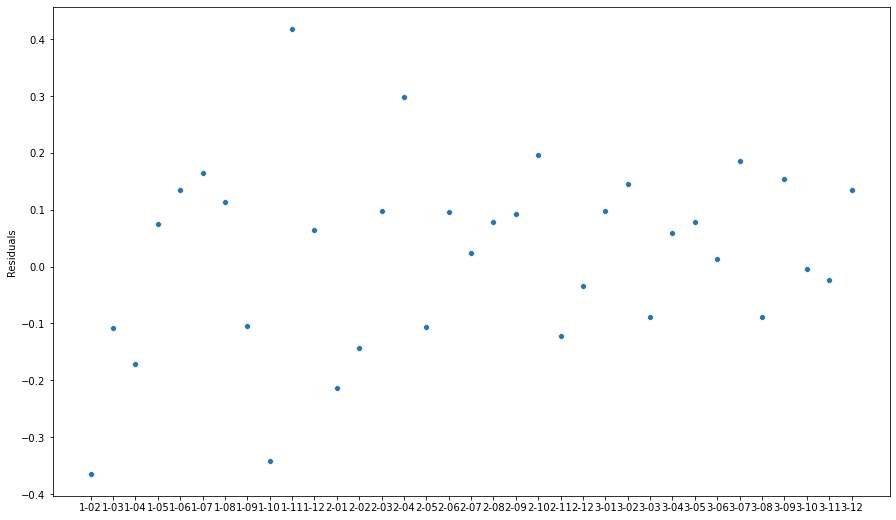

In [26]:
# посмотрим на остатки модели
plt.figure(figsize=(15,9))
sns.scatterplot(data=best_model.resid[1:])
plt.ylabel('Residuals');

Визуально остатки выглядят хорошо. Не видны признаки смещенности, нестационарности или какой-либо зависимости.

In [27]:
# проверим несмещенность остатков с помощью критерия знаков
print("Критерий знаков для остатков: pvalue =", sign_test(best_model.resid[1:])[1])

Критерий знаков для остатков: pvalue = 0.31050465907901503


In [28]:
# проверим стационарность остатков с помощью критерия Дики-Фуллера
print("Критерий Дики-Фуллера для остатков: pvalue =", sm.tsa.stattools.adfuller(best_model.resid[1:])[1])

Критерий Дики-Фуллера для остатков: pvalue = 0.10947447118927561


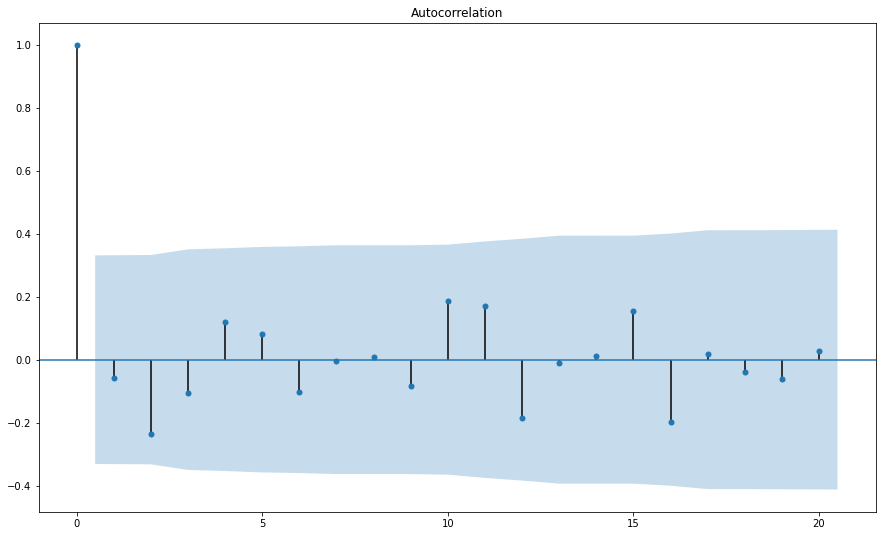

In [31]:
# проверим остатки на автокорреляцию с помощью графика
_, ax = plt.subplots(figsize=(15,9))
sm.graphics.tsa.plot_acf(best_model.resid[1:].values.squeeze(), lags=20, ax=ax);

Критерий знаков не отверг гипотезу о несмещенности остатков. График автокорреляции показывает, что остатки независимы. А вот критерий Дики-Фуллера не стал отвергать гипотезу о нестационарности остатков даже для уровня ошибки 10% (но тут можно сделать поправку на то, что у нас довольно короткий ряд). Также вспомним, что в `summary` критерии Льюнга-Бокса и Харке-Бера не стали отвергать гипотезу о нормально распределении остатков. В общем, будем считать, что остатки у нашей модели получились достаточно хорошие.

In [32]:
# посмотрим, насколько хорошо наша модель приближает исходный временной ряд
shampoo['Model'] = inv_boxcox(best_model.fittedvalues, lmbd)

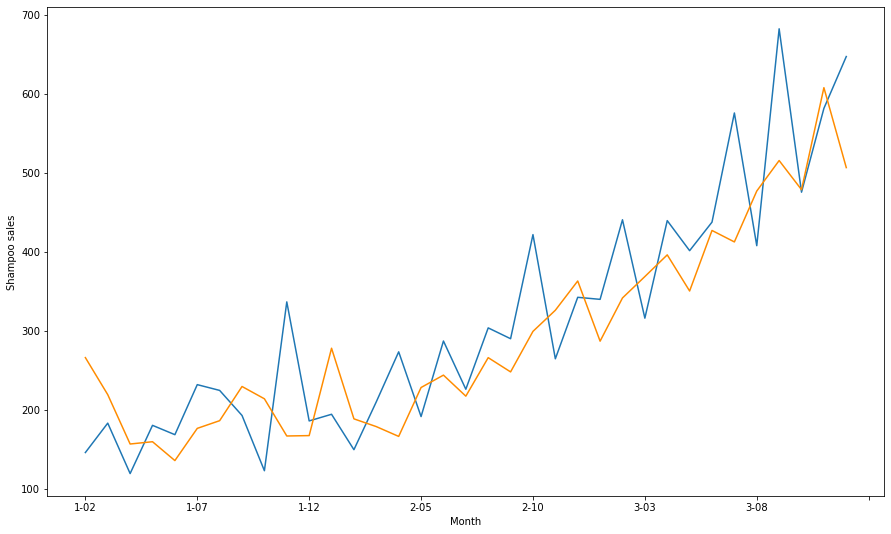

In [33]:
plt.figure(figsize=(15,9))
shampoo['Sales'][1:].plot()
shampoo['Model'][1:].plot(color='darkorange')
plt.ylabel('Shampoo sales');

Картина получилась не очень красивой. Но сделаем скидку на то, что в нашей модели всего лишь два параметра $p$ и $d$. И модели сложно хорошо подстроиться под фактический ряд.

In [34]:
# сделаем прогноз на 3 месяца
plot_shampoo = shampoo[['Sales','Model']]
future = pd.DataFrame(index=['4-01', '4-02', '4-03'], columns= plot_shampoo.columns)
plot_shampoo = pd.concat([plot_shampoo, future])

In [35]:
forecast = inv_boxcox(best_model.predict(start=37, end=39), lmbd)
forecast.index = ['4-01', '4-02', '4-03']

In [37]:
plot_shampoo.loc[forecast.index, ['Model']] = forecast

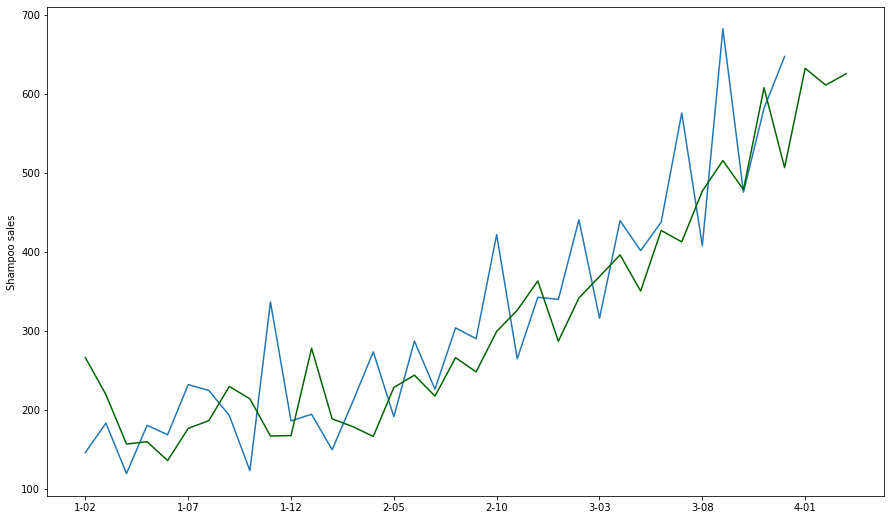

In [38]:
plt.figure(figsize=(15,9))
plot_shampoo['Sales'][1:].plot()
plot_shampoo['Model'][1:].plot(color='darkgreen')
plt.ylabel('Shampoo sales');